# Test notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import src.utils as ut
import src.fuzz as fz
import src.classif as cl

## Visualize testing function

In [22]:
# Number of dimensions
dim = 4
nb_classes = 3
nb_points_per_class = 100

# Create 16D centers with increasingly positive values
centers = [
    np.full(dim, 5.0),   # Center for class 0
    np.full(dim, 10.0),  # Center for class 1
    np.full(dim, 15.0),  # Center for class 2
]

# Create small positive definite covariance matrices for each class
sigmas = []
for _ in range(nb_classes):
    A = np.random.rand(dim, dim) * 0.2  # keep values small
    sigma = np.dot(A, A.T) + np.eye(dim) * 0.5  # ensure positive definite and symmetric
    sigmas.append(sigma)

# Labels for each class
labels = list(range(nb_classes))

# Generate data
data, data_labels = ut.generate_gaussian_dataset(centers, sigmas, labels, nb_points_per_class)

# Keep only samples with all positive values
positive_mask = np.all(data > 0, axis=1)
data = data[positive_mask]
data_labels = data_labels[positive_mask]

print(f"Generated {data.shape[0]} all-positive samples in {dim}D space.")

Generated 300 all-positive samples in 4D space.


In [23]:
# Normalize data
data_norm = fz.batch_norm(data)
data_norm

array([[1.        , 0.77615266, 0.92417533, 0.        ],
       [0.        , 1.        , 0.55595211, 0.72383331],
       [0.        , 0.87670134, 1.        , 0.64343751],
       ...,
       [0.94611278, 0.93711303, 1.        , 0.        ],
       [0.        , 1.        , 0.31300353, 0.37676655],
       [0.        , 0.09258487, 1.        , 0.19947334]], shape=(300, 4))

### Sim Level 1

In [24]:
np.random.randint(100)

76

In [25]:
# Loop to see
for i in range(20):
    X = data_norm[np.random.randint(data_norm.shape[0])]
    Y = data_norm[np.random.randint(data_norm.shape[0])]

    sim1 = fz.SimLevel1(
        X = X,
        Y = Y,
    )
    print(f"SimLevel1: {sim1.score()}")


SimLevel1: 0.0914600659568992
SimLevel1: 0.14776078353017644
SimLevel1: 0.4252335121742213
SimLevel1: 0.04269940592812617
SimLevel1: 0.18749420534274958
SimLevel1: 0.33994045848890847
SimLevel1: 0.08591750627042839
SimLevel1: 0.2765813534016185
SimLevel1: 0.2341343413219335
SimLevel1: 0.6479039052449957
SimLevel1: 0.6296425406396547
SimLevel1: 0.7277629807723403
SimLevel1: 0.4470819316354164
SimLevel1: 0.7710562040237771
SimLevel1: 0.36266432672980276
SimLevel1: 0.6134021568717215
SimLevel1: 0.6079063239883022
SimLevel1: 0.02742725425035695
SimLevel1: 0.19818251132409895
SimLevel1: 0.4826988100483082


In [54]:
class KFuzz(cl.KNN):
    def __init__(self, input_dimension, k=3, sim=fz.SimLevel1):
        """ KNN avec une distance de type fuzz
            k: le nombre de voisins à prendre en compte
            sim: la fonction de similarité à utiliser
        """
        super().__init__(input_dimension=input_dimension, k=k)
        self.sim = sim

    def score(self, x):
        from collections import Counter
        """ Rend la proportion des labels parmi les k ppv de x (valeur réelle)
            x: une description : un ndarray
        """
        # Compute similarity between x and all points in desc_set
        similarity = np.array([self.sim(x, desc).score() for desc in self.desc_set])
        # print(f"Similarity: {similarity}")

        # distances = np.sqrt(np.sum((self.desc_set - x) ** 2, axis=1))
        nearest_indices = np.argsort(similarity)[:self.k]
        # print(f"Nearest indices: {nearest_indices}")
        nearest_labels = self.label_set[nearest_indices]
        # print(f"Nearest labels: {nearest_labels}")
        
        label_counts = Counter(nearest_labels)
        # print(f"Label counts: {label_counts}")
        return max(label_counts.items(), key=lambda item: (item[1], -item[0]))[0]

    def predict(self, x):
        """ Rend la prédiction sur x (label de 0 à 9)
            x: une description : un ndarray
        """
        return int(self.score(x))

    def train(self, desc_set, label_set):
        """ Permet d'entraîner le modèle sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        self.desc_set = desc_set
        self.label_set = label_set

In [55]:
kf = KFuzz(input_dimension=data_norm.shape[1], k=3, sim=fz.SimLevel1)

In [56]:
kf.train(data_norm, data_labels)

In [57]:
kf.predict(data_norm[0])

0

In [58]:
data_labels[0]

np.int64(0)

In [72]:
import copy
import numpy as np
import time

def leave_one_out(C, DS, time_counter=False):
    """ Classifieur * tuple[array, array] -> float
    """
    ###################### A COMPLETER 
    pt = 0
    Xm, Ym = DS

    if time_counter:
        tic = time.time()
    for i in range(len(Xm)):
        Xtest, Ytest = Xm[i], Ym[i]
        
        Xapp, Yapp = np.array(list(Xm[:i])+list(Xm[i+1:])), np.array(list(Ym[:i])+list(Ym[i+1:]))

        cl = copy.deepcopy(C)
        cl.train(Xapp,Yapp)

        if cl.accuracy([Xtest], [Ytest]) == 1 : pt+=1

    if time_counter:
        toc = time.time()
        print(f'Result in {(toc-tic):0.4f} seconds.')
    
    return pt/len(Xm)

    #################################


In [75]:
leave_one_out(
    C = kf, 
    DS = (data_norm, data_labels), time_counter=True
)

Result in 13.0212 seconds.


0.3466666666666667

Leave one out avec k = 1
Leave one out avec k = 2
Leave one out avec k = 3
Leave one out avec k = 4
Leave one out avec k = 5
Leave one out avec k = 6
Leave one out avec k = 7
Leave one out avec k = 8
Leave one out avec k = 9
Leave one out avec k = 10
Result in 120.8726 seconds.
Result: [0.33666666666666667, 0.35, 0.31333333333333335, 0.31666666666666665, 0.32666666666666666, 0.34, 0.32666666666666666, 0.3433333333333333, 0.30333333333333334, 0.30333333333333334]


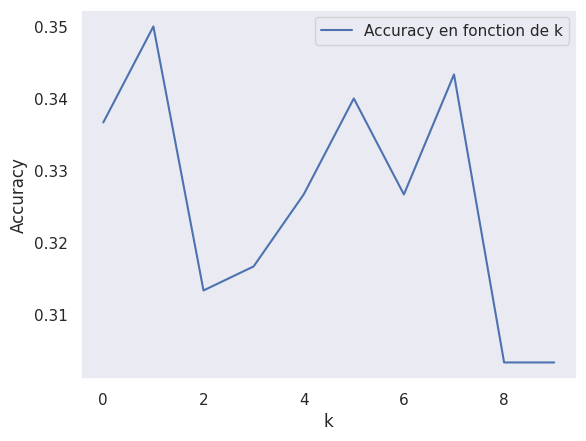

In [76]:
l = []

tic = time.time()
for k in range(1,11): 
  print(f"Leave one out avec k = {k}")
  
  res = leave_one_out(
        C = KFuzz(input_dimension=data_norm.shape[1], k=k, sim=fz.SimLevel1), 
        DS = (data_norm, data_labels)
    )
  l.append(res)

toc = time.time()
print(f"Result in {(toc-tic):0.4f} seconds.")
print(f"Result: {l}")
plt.plot(l, label="Accuracy en fonction de k")
plt.ylabel("Accuracy")
plt.xlabel("k")
plt.grid()
plt.legend()

In [77]:
s = {1,2,3,4,5,6,7,89}
s2 = {1,2,3,4,5,6,7,8}

s.difference(s2)

{89}